In [14]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [15]:
ds = xr.open_dataset("../data/Paper_ds/post_CWU_GAT_2023.nc")[['detrend_input_n', 'detrend_input_e','detrend_input_z', 'final_input_n', 'final_input_e','final_input_z']]
ds

<xarray.Dataset>
Dimensions:          (station: 518, time: 5113)
Coordinates:
  * station          (station) object 'AGNS' 'ALBH' 'ANAT' ... 'YONC' 'ZSE1'
  * time             (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31
    longitude        (station) float64 ...
    latitude         (station) float64 ...
    height           (station) float64 ...
Data variables:
    detrend_input_n  (station, time) float32 ...
    detrend_input_e  (station, time) float32 ...
    detrend_input_z  (station, time) float32 ...
    final_input_n    (station, time) float32 ...
    final_input_e    (station, time) float32 ...
    final_input_z    (station, time) float32 ...
Attributes:
    dataset source:   CWU daily solution from earthscope
    data processing:  raw data are detrended for each channel (detrend_input*...

In [16]:
ds_fit = xr.open_dataset("../fit_daily_CWU.nc").sel(time=slice(ds.time.data[0], ds.time.data[-1]))
ds_fit

<xarray.Dataset>
Dimensions:  (station: 518, time: 5113)
Coordinates:
  * station  (station) object 'AGNS' 'ALBH' 'ANAT' ... 'YOCR' 'YONC' 'ZSE1'
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31
Data variables:
    n        (station, time) float64 ...
    e        (station, time) float64 ...
    z        (station, time) float64 ...

In [17]:
def haversine_nb(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = np.radians(lon1), np.radians(lat1), np.radians(lon2), np.radians(lat2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    return 6367 * 2 * np.arcsin(np.sqrt(a))

def calculate_distances(lon, lat):
    n = len(lon)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distances[i, j] = haversine_nb(lon[i], lat[i], lon[j], lat[j])
    return distances

In [18]:
lon = ds['longitude'].values
lat = ds['latitude'].values
distances = calculate_distances(lon, lat)
distances

array([[  0.        , 650.16161502, 678.59332496, ..., 364.57713417,
        135.09541517, 546.25196396],
       [650.16161502,   0.        , 540.48382279, ..., 359.80101686,
        528.67551629, 156.22361306],
       [678.59332496, 540.48382279,   0.        , ..., 366.91386396,
        558.84258501, 405.73159882],
       ...,
       [364.57713417, 359.80101686, 366.91386396, ...,   0.        ,
        229.73675129, 214.74315393],
       [135.09541517, 528.67551629, 558.84258501, ..., 229.73675129,
          0.        , 415.03061105],
       [546.25196396, 156.22361306, 405.73159882, ..., 214.74315393,
        415.03061105,   0.        ]])

In [19]:
distances.shape

(518, 518)

In [20]:
def compute_distant_avg(data, station, distances, threshold_distance):
    distant_stations = np.where(distances[station] >= threshold_distance)[0]
    if len(distant_stations) > 0:
        return data.isel(station=distant_stations).mean(dim='station')
    else:
        return xr.full_like(data.isel(station=station), np.nan)

In [21]:
%%time
threshold_distance = 400  # km
for c in ['e', 'n', 'z']:
    ds[f'detrend_pred_{c}'] = xr.concat([compute_distant_avg(ds[f'detrend_input_{c}'], i, distances, threshold_distance) for i in range(len(lon))], dim='station')
    ds[f'detrend_denoised_{c}'] = ds[f'detrend_input_{c}'] - ds[f'detrend_pred_{c}']
    ds[f'final_denoised_{c}'] = ds[f'detrend_denoised_{c}'] + ds_fit[c]
    ds[f'final_pred_{c}'] = ds[f'detrend_pred_{c}'] + ds_fit[c]
ds

CPU times: user 33.3 s, sys: 3.55 s, total: 36.8 s
Wall time: 37 s


<xarray.Dataset>
Dimensions:             (station: 518, time: 5113)
Coordinates:
  * station             (station) object 'AGNS' 'ALBH' 'ANAT' ... 'YONC' 'ZSE1'
  * time                (time) datetime64[ns] 2010-01-01 ... 2023-12-31
    longitude           (station) float64 -124.1 -123.5 -117.1 ... -123.3 -122.2
    latitude            (station) float64 42.55 48.39 46.13 ... 43.63 47.29
    height              (station) float64 ...
Data variables: (12/18)
    detrend_input_n     (station, time) float32 ...
    detrend_input_e     (station, time) float32 ...
    detrend_input_z     (station, time) float32 ...
    final_input_n       (station, time) float32 ...
    final_input_e       (station, time) float32 ...
    final_input_z       (station, time) float32 ...
    ...                  ...
    final_denoised_n    (station, time) float64 nan nan nan ... -0.1111 nan
    final_pred_n        (station, time) float64 -0.116 -0.1162 ... -0.1114 nan
    detrend_pred_z      (station, time) float32 -0.005294 -0.003315 ... nan
    detrend_denoised_z  (station, time) float32 nan nan nan ... 0.003819 nan
    final_denoised_z    (station, time) float64 nan nan nan ... -0.01357 nan
    final_pred_z        (station, time) float64 -0.003635 -0.001655 ... nan
Attributes:
    dataset source:   CWU daily solution from earthscope
    data processing:  raw data are detrended for each channel (detrend_input*...

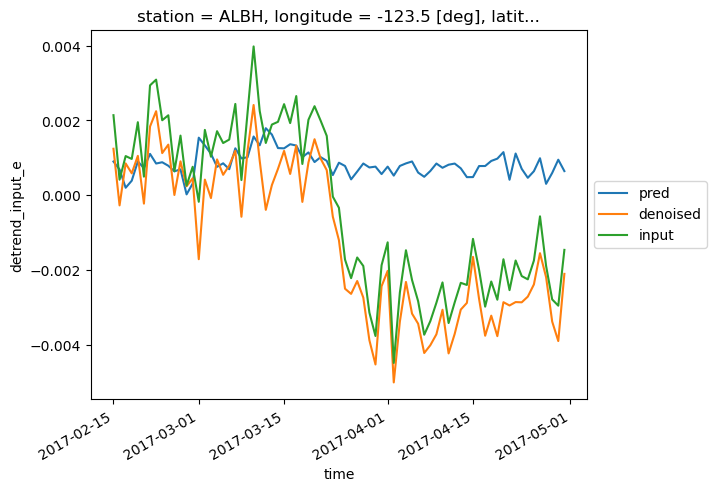

In [22]:
ds.detrend_pred_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="pred")
ds.detrend_denoised_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="denoised")
ds.detrend_input_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="input")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

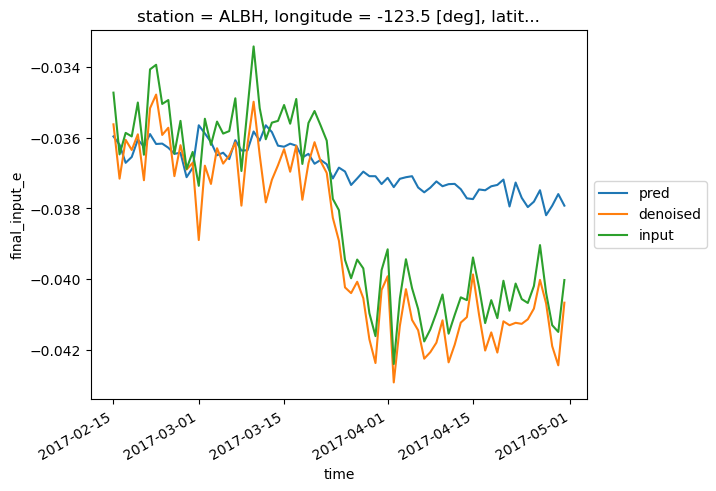

In [23]:
ds.final_pred_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="pred")
ds.final_denoised_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="denoised")
ds.final_input_e.sel(station='ALBH').sel(time=slice('2017-02-15', '2017-04-30')).plot(label="input")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

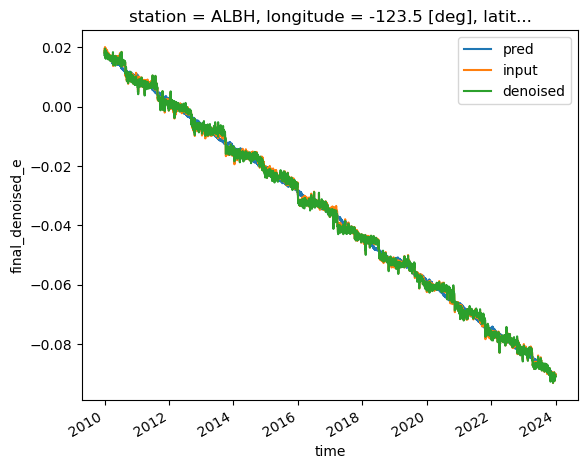

In [24]:
ds.final_pred_e.sel(station='ALBH').plot(label="pred")
ds.final_input_e.sel(station='ALBH').plot(label="input")
ds.final_denoised_e.sel(station='ALBH').plot(label="denoised")
plt.legend()

In [25]:
ds

<xarray.Dataset>
Dimensions:             (station: 518, time: 5113)
Coordinates:
  * station             (station) object 'AGNS' 'ALBH' 'ANAT' ... 'YONC' 'ZSE1'
  * time                (time) datetime64[ns] 2010-01-01 ... 2023-12-31
    longitude           (station) float64 -124.1 -123.5 -117.1 ... -123.3 -122.2
    latitude            (station) float64 42.55 48.39 46.13 ... 43.63 47.29
    height              (station) float64 ...
Data variables: (12/18)
    detrend_input_n     (station, time) float32 ...
    detrend_input_e     (station, time) float32 ...
    detrend_input_z     (station, time) float32 ...
    final_input_n       (station, time) float32 ...
    final_input_e       (station, time) float32 ...
    final_input_z       (station, time) float32 ...
    ...                  ...
    final_denoised_n    (station, time) float64 nan nan nan ... -0.1111 nan
    final_pred_n        (station, time) float64 -0.116 -0.1162 ... -0.1114 nan
    detrend_pred_z      (station, time) float32 -0.005294 -0.003315 ... nan
    detrend_denoised_z  (station, time) float32 nan nan nan ... 0.003819 nan
    final_denoised_z    (station, time) float64 nan nan nan ... -0.01357 nan
    final_pred_z        (station, time) float64 -0.003635 -0.001655 ... nan
Attributes:
    dataset source:   CWU daily solution from earthscope
    data processing:  raw data are detrended for each channel (detrend_input*...

In [26]:
ds.to_netcdf("../data/Paper_ds/avg_position_denoising_400km_CWU.nc")